## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pycountry
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy
import warnings
from func_library import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)
# pd.options.display.float_format = '{:.0f}'.format
np.random.seed(42)

## Reading (Run Once)

In [2]:
stack_overflow, skills_list, employments = StackOverflowData.generate_aggregate_df(only_data_science_devs=True)
exchange_rate_df = generate_exchange_rates_df()
ppp_df = read_ppp()
stack_overflow = StackOverflowData.generate_2023_usd_comp(stack_overflow, exchange_rate_df, ppp_df)

ai_salaries_df = AISalariesData.generate_df()
ai_salaries_df = AISalariesData.generate_2023_usd_comp(ai_salaries_df, exchange_rate_df, ppp_df)
ai_salaries_df = pd.concat([ai_salaries_df, pd.get_dummies(ai_salaries_df["job_title"], dtype='int')], axis=1)
ai_salaries_df = ai_salaries_df.drop("job_title", axis=1)

ai_salaries_df = ai_salaries_df.dropna(subset=['usd_2023'])
stack_overflow = stack_overflow.dropna(subset=['usd_2023'])

Country code MM not found in pycountry
Country code ME not found in pycountry
Country code PS not found in pycountry
Country code AD not found in pycountry
Country code SY or year 2020 not found in the PPP DataFrame
Country code None or year 2023 not found in the PPP DataFrame
Country code SY or year 2019 not found in the PPP DataFrame
Country code SY or year 2019 not found in the PPP DataFrame
Country code SY or year 2021 not found in the PPP DataFrame
Country code SY or year 2021 not found in the PPP DataFrame
Country code SY or year 2021 not found in the PPP DataFrame
Country code None or year 2019 not found in the PPP DataFrame
Country code SY or year 2021 not found in the PPP DataFrame
Country code None or year 2021 not found in the PPP DataFrame
Country code None or year 2021 not found in the PPP DataFrame
Country code None or year 2019 not found in the PPP DataFrame
Country code None or year 2019 not found in the PPP DataFrame
Country code None or year 2021 not found in the PPP 

## Analysis

### Does how does experience look on the salaries?
- What happens if we break it down by country?
- Does the number of X experience level correlate a higher salary?
- What if we look at the degree?

'SE': 'Senior',
'MI': 'Middle',
'EN': 'Entry',
'EX': 'Executive'

In [231]:
# more workable until we go by skills
s_o = stack_overflow.drop(skills_list, axis=1)

IQR = s_o["usd_2023"].quantile(0.75) - s_o["usd_2023"].quantile(0.25)
q3 = s_o["usd_2023"].quantile(0.75)
s_o = s_o[s_o['usd_2023'] < q3 + (1.5*IQR)]
s_o["edlevel"] = s_o["edlevel"].replace({
    "Some College": "<=Bachelor's",
    "Associate's": "<=Bachelor's",
    "Secondary": "<=Bachelor's",
    "Elementary": "<=Bachelor's",
    "Else": "<=Bachelor's",
    "Bachelor's": "<=Bachelor's"
})

s_o["yearscodepro"] = s_o["yearscodepro"].replace({'Less than 1 year': 0, 'More than 50 years': 50})
s_o["yearscodepro"] = s_o["yearscodepro"].fillna(0)
s_o["yearscodepro"] = s_o["yearscodepro"].astype(int)
s_o["experience_level"] = pd.cut(
                                x=s_o["yearscodepro"], 
                                bins=[0, 2, 5, 10, np.inf],
                                labels=['Entry', 'Middle', 'Senior', 'Executive']
                            )

In [232]:
temp_so = s_o[["year", "experience_level", "country", "usd_2023"] + list(employments)]
temp_ai = ai_salaries_df[["work_year", "experience_level", "employee_residence", "usd_2023"] + list(employments)]
temp_ai.columns = temp_so.columns


merged = pd.concat([temp_so, temp_ai], axis=0, ignore_index=True)
IQR = merged["usd_2023"].quantile(0.75) - merged["usd_2023"].quantile(0.25)
q3 = merged["usd_2023"].quantile(0.75)
outliers = merged[merged['usd_2023'] > q3 + (1.5*IQR)]
print(f"Outliers: {len(outliers)} vs. Normal: {len(merged)}")
merged = merged[merged['usd_2023'] < q3 + (1.5*IQR)]
merged.loc[:, "year"] = merged.loc[:, "year"].astype('int64')
merged["experience_level"] = merged["experience_level"].replace({'SE': 'Senior', 'MI': 'Middle', 'EN': 'Entry', 'EX': 'Executive'})

Outliers: 589 vs. Normal: 53158


In [233]:
ai_salaries_df.columns

Index(['index', 'work_year', 'experience_level', 'employment_type', 'salary',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'usd_2023',
       'analyst', 'data_scientist', 'developer', 'engineer_other',
       'management', 'scientist_other', 'systems_architect'],
      dtype='object')

In [234]:
s_o.columns

Index(['index', 'orgsize', 'convertedcompyearly', 'original_country',
       'employment', 'yearscode', 'sovisitfreq', 'surveyease', 'edlevel',
       'socomm', 'currency', 'yearscodepro', 'country', 'soaccount',
       'sopartfreq', 'age', 'comptotal', 'mainbranch', 'year', 'surveylength',
       'count', 'compensation', 'analyst', 'data_scientist', 'developer',
       'engineer_other', 'management', 'scientist_other', 'systems_architect',
       'usd_2023', 'experience_level'],
      dtype='object')

#### Helper Functions

In [235]:
def get_similar_countries(df: pd.DataFrame, want: int = 10) -> list:
    """
    Get the number of countries that we want so we can index for ANOVA
    Consistent across the years for a good comparison
    """
    groupped = df.groupby('year')
    loc_list = list()
    head = want
    
    while len(loc_list) < want:
        loc_set = set()
        for year, frame in groupped:
            grouped = frame.groupby("country").size().sort_values(ascending=False)
            if not loc_set:
                loc_set = set(grouped.head(head).index)
                continue
            temp_set = set(grouped.head(head).index)
            loc_set = loc_set.intersection(temp_set)
        loc_list = list(loc_set)
        head += 1
    return loc_list

### Is there a significant (statistical) difference between salaries in countries?
- When we remove outliers what happens?
- Do we see a trend in outliers?
- Can we break down what we see in the two or three highest salary countries?

In [237]:
countries = get_similar_countries(merged, 20)

In [238]:
groupped = merged.groupby("year")

In [239]:
dfs = []
for year, frame in groupped:
    t_tests = np.zeros((len(countries), len(countries)))
    frame = frame[frame["country"].isin(countries)]
    for i in range(len(countries)):
        control = countries[i]
        for j in range(i+1, len(countries)):
            exp = countries[j]
            d1 = frame[frame["country"] == control]
            d2 = frame[frame["country"] == exp]
            result = pg.ttest(d1.usd_2023, d2.usd_2023).round(3) # this is 2 tailed
            t_tests[j, i] = result.loc["T-test", "p-val"]
    df = pd.DataFrame(t_tests, columns=countries, index=countries)
    dfs.append(df)

In [240]:
# not a heatmap for value
# is everything kind of moving? do relationships stay throughout the years?
# # better visualization?
# fabricated metric? see correlation between the years
# # comprehensive view of this
# heatmap works for all the years into a single metric with the heat map
# growth rate between year
# collapse data set and get deltas from start to end
# # in between years and see correlations between growth
# fig, axes = plt.subplots(5, 1, figsize=(6, 25))
# for i in range(len(dfs)):
#     sns.heatmap(dfs[i], ax=axes[i])
# # plt.show()

In [241]:
from collections import defaultdict

stat_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
year = 2019

for df in dfs:
    for start in range(len(df)):
        r = start
        c = 0
        dec_row = False
        while c < len(df) and r < len(df):
            
            if r == c: # then we are on the diagonal
                dec_row = True
                r += 1
                continue

            row = df.index[r]
            col = df.columns[c]
            
            if df.iloc[r, c] < 0.05:
                val = 1
            else:
                val = 0
                    
            if not dec_row: # we are going across
                stat_counts[str(year)][row][col] = val
                c += 1
            else:
                stat_counts[str(year)][col][row] = val
                r += 1
    year += 1

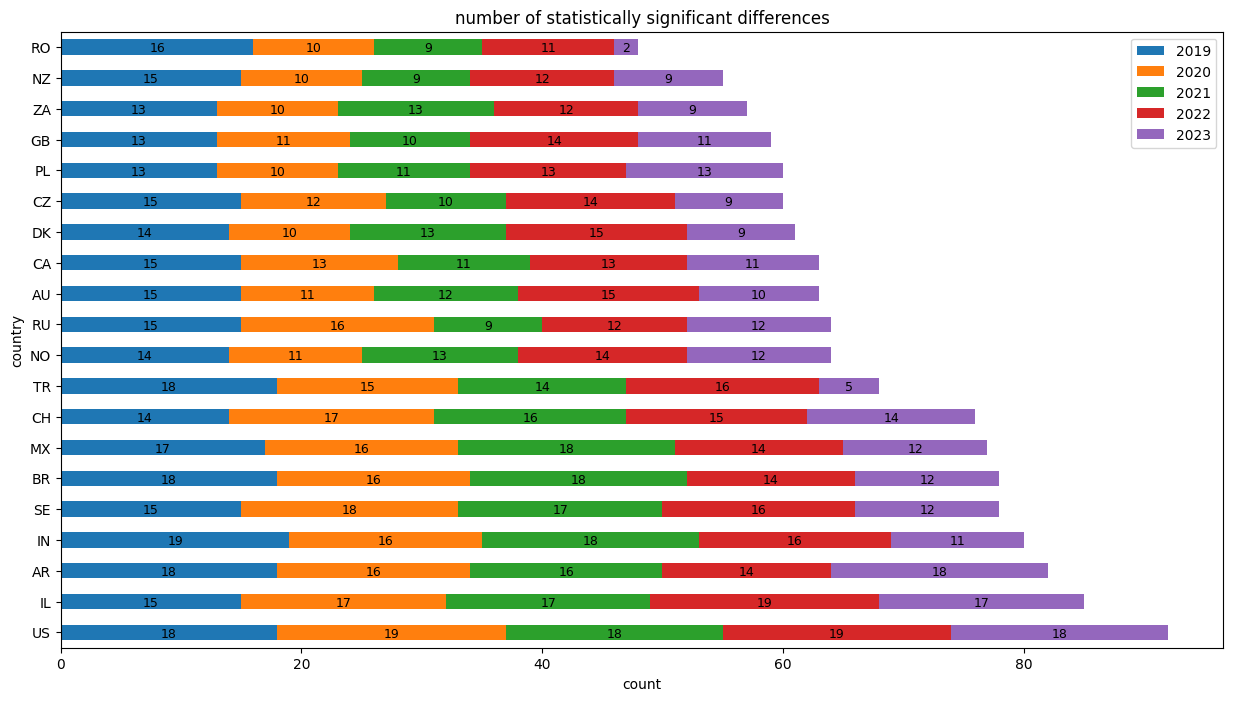

In [242]:
# {year: {country : {country: num}}}
result = {}
for year, count_dict in stat_counts.items():
    counts = [] 
    for key, value in count_dict.items():
        counts.append((key, sum(value.values())))
    result[year] = counts

transformed_data = {}
for key, tuples in result.items():
    for tup in tuples:
        index, value = tup[0], tup[1]
        if index not in transformed_data:
            transformed_data[index] = {}
        transformed_data[index][key] = value

# Create DataFrame
working = pd.DataFrame.from_dict(transformed_data, orient='index')
working["total"] = working[["2019", "2020", "2021", "2022", "2023"]].sum(axis=1)
working = working.sort_values("total", ascending=False)

fig, ax = plt.subplots(figsize=(15, 8))
working[["2019", "2020", "2021", "2022", "2023"]].plot(kind="barh", stacked=True, ax=ax)
ax.set_title("number of statistically significant differences")
ax.set_xlabel('count')
ax.set_ylabel('country')

# https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
y_offset = -0.4
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_width()),
      ha='center',
      color='k',
      size=9
  )

plt.show()

In [243]:
def cull_country(frame: pd.DataFrame, cull_factor=20) -> set:
    """
    Given a particular minimum (cull_factor) find the countries in common among
    frames.
    """
    union = []
    grouped = frame.groupby("country").count()
    grouped = grouped[grouped["year"] > cull_factor]
    return list(grouped.index)

In [244]:
important = cull_country(location, 10)

In [245]:
to_choro = merged[merged["country"].isin(important)].groupby("country")["usd_2023"].mean().reset_index()
to_choro.to_csv("to_choro.csv")
to_choro.sort_values("usd_2023", ascending=False).head(15)

,country,usd_2023
42,HR,162188.411177
102,US,137757.568540
87,SA,122647.305432
46,IL,116717.777247
92,SN,113525.395474
89,SG,106652.997605
15,CH,105321.666272
84,RO,105186.192481
45,IE,100938.265125
106,ZA,100098.831557


Color banding higher education, anything like highschool or lower: 2 colors but different gradients.

Cut 2023

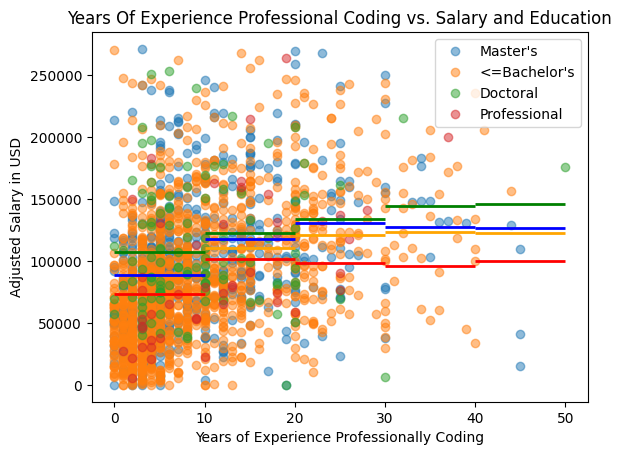

In [246]:
edu = s_o[~s_o["edlevel"].isin(['nan'])]
knots = [0, 10, 20, 30, 40, 50]
colors = {"Master's": "blue", "<=Bachelor's": "orange", "Doctoral": "green", "Professional": "red"}
for school in edu["edlevel"].unique():
    temp = edu[edu["edlevel"] == school].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=school, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = edu[edu["yearscodepro"].between(gt, lt)].groupby('edlevel')["usd_2023"].mean()
        plt.hlines(grouped[school], xmin=lt, xmax=gt, color=colors[school], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Education")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc="best")
plt.show()

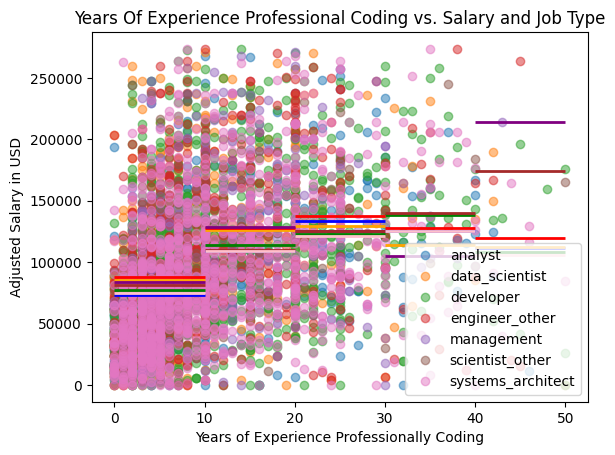

In [247]:
knots = [0, 10, 20, 30, 40, 50]
colors = {
    "analyst": "blue", 
    "data_scientist": "orange", 
    "developer": "green", 
    "engineer_other": "red", 
    "management": "purple", 
    "scientist_other": "brown", 
    "systems_architect": "pink"
}
for job in employments:
    temp = s_o[s_o[job] == 1].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=job, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = temp[temp["yearscodepro"].between(gt, lt)]["usd_2023"].mean()
        plt.hlines(grouped, xmin=lt, xmax=gt, color=colors[job], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Job Type")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc="best")
plt.show()

### Between these data practitioners which skill showed up the most?
- Can we break this down further by location, or even degree or years of experience after binning?
- Can we say more skills CORRELATES to a higher salary?

In [248]:
relevant_skills = [skill for skill in skills_list if "hww" in skill]
language = [skill for skill in relevant_skills if "lg" in skill]
database = [skill for skill in relevant_skills if "db" in skill]
# platform = [skill for skill in relevant_skills if "pf" in skill]
# misctool = [skill for skill in relevant_skills if "mf" in skill]

In [249]:
# language: lg, database: db, misc tech: mt, platform: pf
s_job = pd.concat([s_o, stack_overflow[relevant_skills]], axis=1)
s_job["total_skills"] = s_job[relevant_skills].sum(axis=1)

q3 = s_job["convertedcompyearly"].quantile(0.75)
IQR = s_job["convertedcompyearly"].quantile(0.75) - s_job["convertedcompyearly"].quantile(0.25)

s_job = s_job[s_job["convertedcompyearly"] < q3 + (1.5*IQR)]

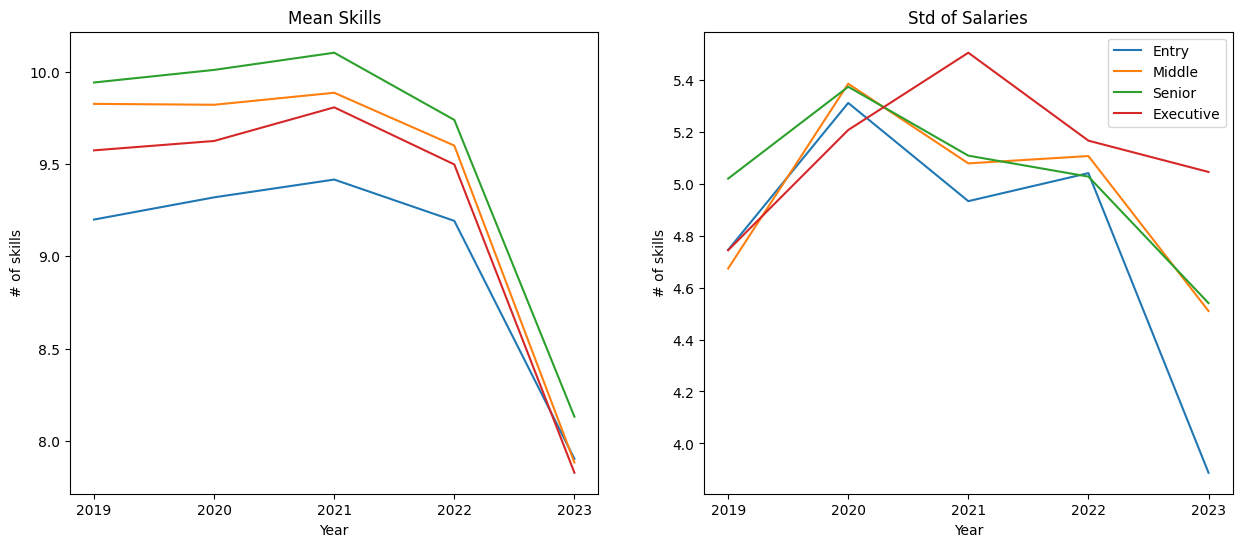

In [250]:
skill_groups = s_job.groupby(["year", "experience_level"])["total_skills"].agg(["mean", "median", pd.Series.mode, "std"]).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for level in skill_groups["experience_level"].unique():
    frame = skill_groups[skill_groups["experience_level"] == level]
    axes[0].plot(frame["year"], frame["mean"], label=level)
    axes[1].plot(frame["year"], frame["std"], label=level)

axes[0].set_title("Mean Skills")
axes[0].set_ylabel("# of skills")
axes[0].set_xlabel("Year")
# axes[0].set_xticks([2019, 2020, 2021, 2022, 2023])
axes[1].set_title("Std of Salaries")
axes[1].set_ylabel("# of skills")
axes[1].set_xlabel("Year")
# axes[1].set_xticks([2019, 2020, 2021, 2022, 2023])

plt.legend(loc="best")
plt.show()

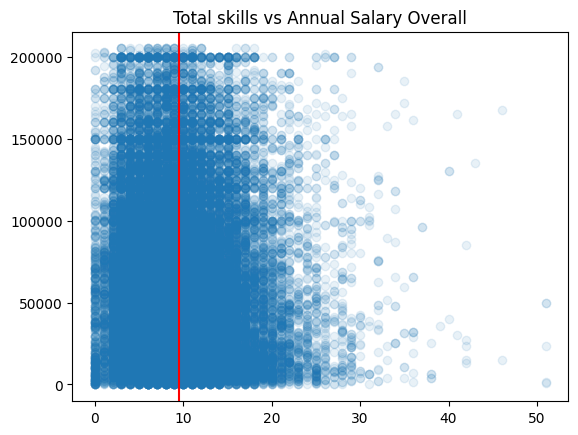

In [251]:
plt.plot(s_job["total_skills"], s_job["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(s_job["total_skills"].mean(), color='red')
plt.title("Total skills vs Annual Salary Overall");

In [252]:
lg_df = s_job[["year", "country", "convertedcompyearly"] + language]
db_df = s_job[["year", "country", "convertedcompyearly"] + database]
# not enough information for the bottom two
# pf_df = s_job[["year"] + platform]
# mt_df = s_job[["year"] + misctool]

In [253]:
# lg_df.groupby(["year", "country"]).sum()

In [254]:
top_lang = lg_df.groupby(["year", "country"]).sum().idxmax(axis=1)
# top_lang = top_lang.loc[()]

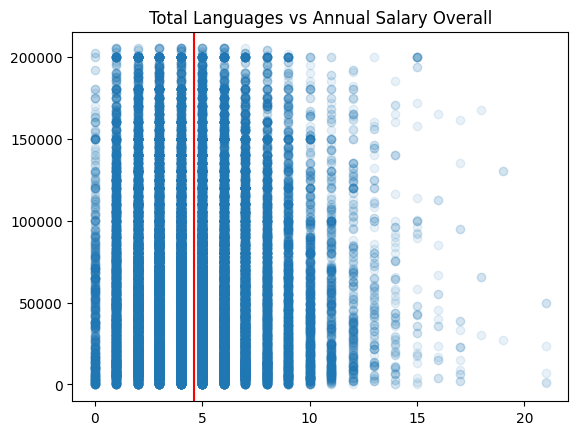

In [255]:
lg_df["total_langs"] = lg_df[language].sum(axis=1)
plt.plot(lg_df["total_langs"], lg_df["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(lg_df["total_langs"].mean(), color='red')
plt.title("Total Languages vs Annual Salary Overall");

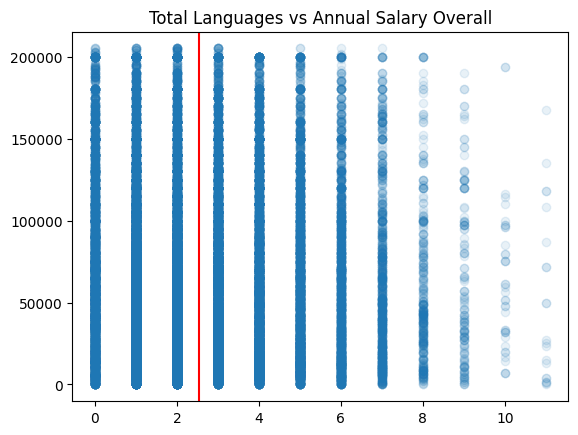

In [256]:
db_df["total_dbs"] = db_df[database].sum(axis=1)
plt.plot(db_df["total_dbs"], db_df["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(db_df["total_dbs"].mean(), color='red')
plt.title("Total Languages vs Annual Salary Overall");

Languages/DB gaining popularity?

### When we break down the data by deltas per year, what do we see?
- Percentage vs absolute?
- Number of degrees and number of experience levels?
- Salaries increasing or decreasing?

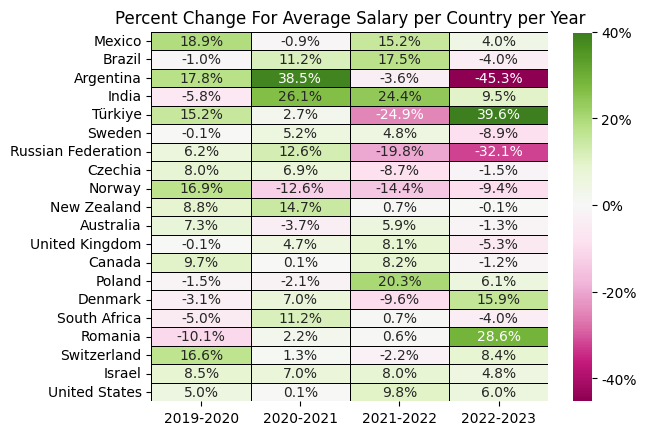

In [278]:
alpha2_to_name = {country.alpha_2: country.name for country in pycountry.countries}

pivot = pd.pivot_table(merged, values="usd_2023", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
pivot.index = [alpha2_to_name[country] for country in pivot.index]

plt.title("Percent Change For Average Salary per Country per Year")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.4,  -0.2, 0, 0.2, 0.4])
cbar.set_ticklabels(['-40%', '-20%', '0%', '20%', '40%'])
plt.show()

Effect of COVID as a confounder

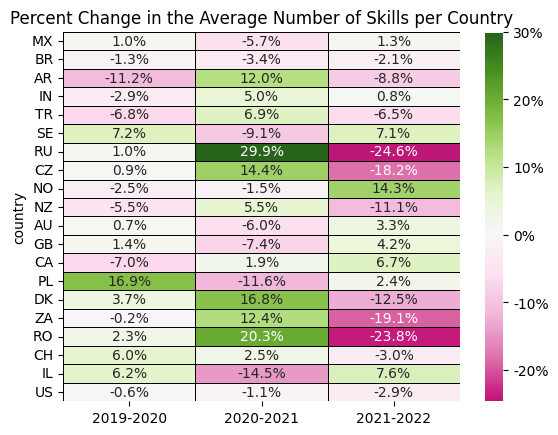

In [276]:
alpha2_to_name = {country.alpha_2: country.name for country in pycountry.countries}
pivot = pd.pivot_table(s_job, values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
plt.title("Percent Change in the Average Number of Skills per Country")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.2, -0.10, 0, 0.1, 0.2, 0.3])
cbar.set_ticklabels(['-20%', '-10%', '0%', '10%', '20%', '30%'])
plt.show()

Around 0, is the key. Divergent where things *close* to 0. White not quite at 0.

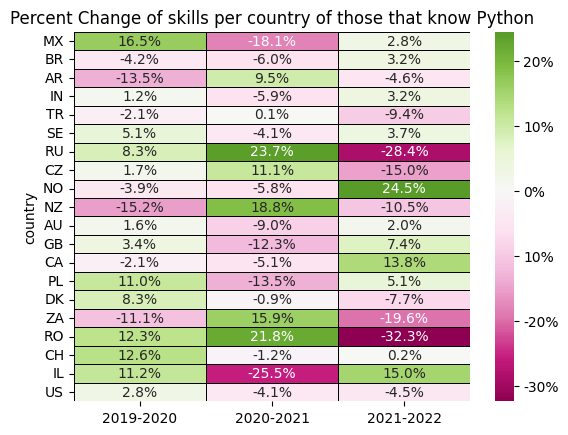

In [274]:
pivot = pd.pivot_table(s_job[s_job["lghww_Python"]==1], values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)

ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
plt.title("Percent Change of skills per country of those that know Python")
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2])
cbar.set_ticklabels(['-30%', '-20%', '10%', '0%', '10%', '20%'])
plt.show()

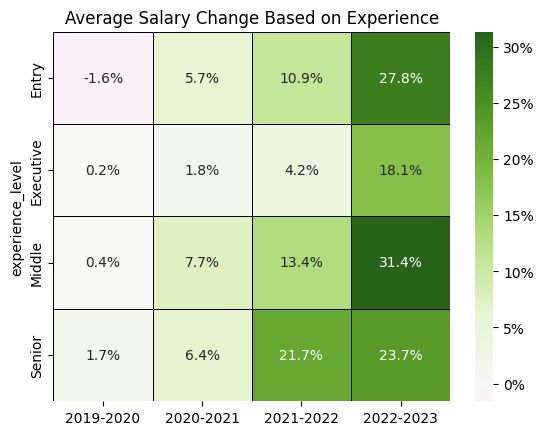

In [260]:
pivot = pd.pivot_table(merged, values="usd_2023", index="experience_level", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change Based on Experience")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3])
cbar.set_ticklabels(['0%', '5%', '10%', '15%', '20%', '25%', '30%'])
plt.show()

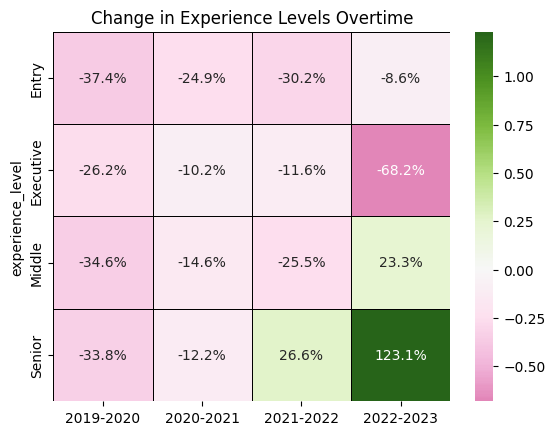

In [261]:
pivot = pd.pivot_table(experience, values="usd_2023", index="experience_level", columns="year", aggfunc="count")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)

plt.title("Change in Experience Levels Overtime")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

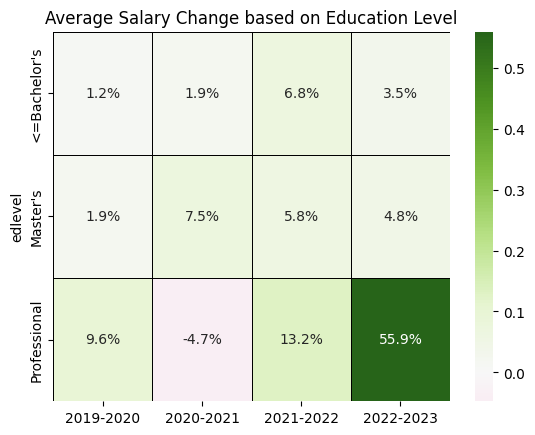

In [262]:
pivot = pd.pivot_table(s_job, values="usd_2023", index="edlevel", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change based on Education Level")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

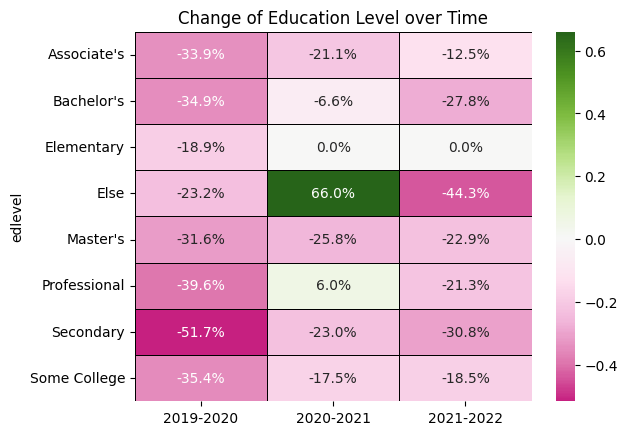

In [263]:
pivot = pd.pivot_table(stack_overflow, values="usd_2023", index="edlevel", columns="year", aggfunc="count")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
plt.title("Change of Education Level over Time")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

In [264]:
alpha2_to_name = {country.alpha_2: country.name for country in pycountry.countries}

In [270]:
sort = merged[merged["country"].isin(countries)].groupby("country")["usd_2023"].mean().sort_values()
countries = list(sort.index)
sort.index = [alpha2_to_name[country] for country in sort.index]
full_countries = list(sort.index)

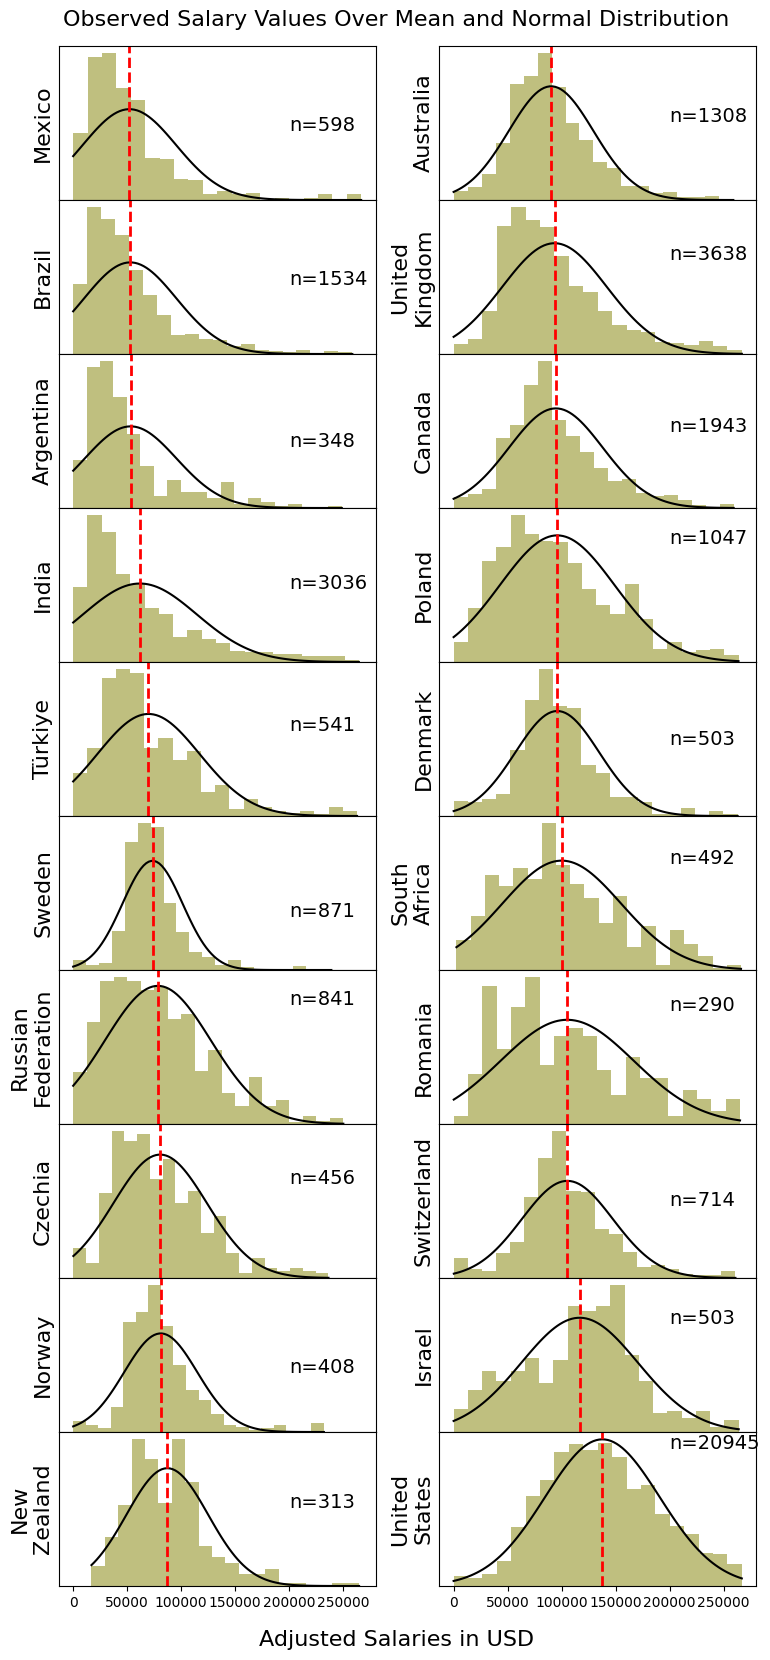

In [335]:
first_half = countries[:len(countries)//2]
second_half = countries[len(countries)//2:]
length = max(len(first_half), len(second_half))

fig, axes = plt.subplots(length, 2, sharex=True, figsize=(9, 20))
for i in range(length):
    working = merged[merged["country"] == first_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"])
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 0].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 0].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel("\n".join(alpha2_to_name[first_half[i]].split(" ")), fontsize=16)
    axes[i, 0].text(200000, 7e-6, f"n={len(working)}", fontsize=14)

    working = merged[merged["country"] == second_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"])
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 1].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 1].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 1].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 1].set_yticks([])
    axes[i, 1].set_ylabel("\n".join(alpha2_to_name[second_half[i]].split(" ")), fontsize=16)
    axes[i, 1].text(200000, 7e-6, f"n={len(working)}", fontsize=14)

fig.text(0.5, 0.08, 'Adjusted Salaries in USD', ha='center', fontsize=16)
fig.text(0.5, 0.89, 'Observed Salary Values Over Mean and Normal Distribution', ha='center', fontsize=16)

plt.subplots_adjust(hspace=0)
plt.savefig("charts/distributions.png")
plt.show()

In [306]:
print(len(merged[merged["country"] == "IL"]))

503


### Choropleth Chart on Salary by Location (need)

### Line Chart of Salary by Location (need)

### Blox Plot of a Country to Show Skew if Any (need)

### Histogram of Countries with Highest Response Rates (need)

### Sunburst Plot (want)